## **Example of calculations of SNR for a range of the boson mass*

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import healpy
import h5py
import os

# Conditions

In [2]:
dObs=8e-3 #en Mpc

# Superrad

In [3]:
alphas = np.linspace(0.001, 0.134, 10)
value=10
wf=[]
from superrad import ultralight_boson as ub
for a in alphas:
    bc= ub.UltralightBoson(spin=0, model="non-relativistic")
    wf.append(bc.make_waveform(10**6,0.5,mu=((a*6.62607e-34*3e8)/(2*np.pi*1.48e9))*(1/1.6e-19), units="physical"))

In [4]:
orbit_file_name='/local/home/dd274198/Documents/lisaenv/keplerian-orbits-1-0-2.h5'
with h5py.File(orbit_file_name, 'r') as fi:
    orbit_t0 = fi.attrs['t0']
    duration=fi.attrs['tduration']
    #print(fi.attrs.keys())
    print(duration)


31536000.0


In [5]:
Tobs=3.0e7
dt=25
N=int(Tobs/dt)
t = orbit_t0 + np.arange(0,1.2*Tobs,dt)
print(len(t))   
print(N) 
print(N*dt)

1440000
1200000
30000000


In [6]:
sec_hour = 3600.0
sec_day=sec_hour*24
sec_year=sec_day*365
t_freq = np.arange(0,10**9*sec_year,10**2*sec_year)
print(len(t))
print(len(t_freq))


1440000
10000000


In [8]:
from lisagwresponse import ReadStrain
LINKS = [12, 23, 31, 13, 32, 21]

import pytdi
import pytdi.michelson
from pytdi.michelson import X2, Y2, Z2
from pytdi import Data
value=10


tab_X2gw = []
for i in range(value):
    tab_X2gw.append([])
    
#tab_A2gw = []
#tab_E2gw = []
#tab_T2gw = []
#for i in range(value):
#    tab_A2gw.append([])
#    tab_E2gw.append([])
#    tab_T2gw.append([])

strain_file='gwresponse_file_b.h5'
    
for a,i in zip(alphas,range(value)):
    thetaObs = np.pi/4 #Observing angle w.r.t. spin axis
    phi=wf[i].phase_gw(t)
    hp,hx,delta = wf[i].strain_amp(t_freq,thetaObs,dObs)
    hp0_f,hx0_f,delta=wf[i].strain_amp(t,thetaObs,dObs)
    hp_f,hx_f=hp0_f*np.cos(phi),hx0_f*np.sin(phi)
    #fgw = wf[i].freq_gw(t_freq)
    
    if os.path.exists(strain_file):
            os.remove(strain_file)
    rs=ReadStrain(t,hp_f,hx_f,strain_interp_order=5,orbits=orbit_file_name, 
    orbit_interp_order=2, dt=dt, size=N,gw_beta=np.pi / 2, gw_lambda=0,t0=orbit_t0+10)
    response=rs.compute_gw_response(rs.t,LINKS)
    rs.write(path=strain_file)
    
    data = Data.from_gws(strain_file, orbit_file_name)
    built_gw_X2 = X2.build(**data.args)
    tab_X2gw[i] = built_gw_X2(data.measurements)
    
    #built_gw_Y2 = Y2.build(**data.args)
    #Y2_gw = built_gw_Y2(data.measurements)
    #built_gw_Z2 = Z2.build(**data.args)
    #Z2_gw = built_gw_Z2(data.measurements)

    #tab_A2gw[i]=((Z2_gw - X2_gw) / np.sqrt(2))
    #tab_E2gw[i]=((X2_gw - 2 * Y2_gw + Z2_gw) / np.sqrt(6))
    #tab_T2gw[i]=((X2_gw + Y2_gw + Z2_gw) / np.sqrt(3))
    

In [ ]:
#fonction Périodogramme

In [9]:
def Pd_num(x,dt):
    #window=np.blackman(len(x))
    window=1
    #N_w=np.sum(window**2)
    N_w=len(x)
    return dt*(2/N_w)*(np.abs(np.fft.rfft(window*x)))**2

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import ldc
from ldc.lisa.noise import get_noise_model
from ldc.lisa.noise import NumericNoise
AddLDC = True

f= np.fft.rfftfreq(N,d=dt)


tab_PSD_sciRD_X2usb = []
for i in range(value):
    tab_PSD_sciRD_X2usb.append([])
    
tab_Pd_X2n = []
for i in range(value):
    tab_Pd_X2n.append([])
    
#Pd_A2n = []
#Pd_E2n = []
#Pd_T2n = []
#for i in range(value):
#   Pd_A2n.append([])
#   Pd_E2n.append([])
#   Pd_T2n.append([])
    
    
for a,i in zip(alphas,range(value)):
    ## Noise level in the Science Requirement Document
    tab_PSD_sciRD_X2usb[i] = get_noise_model("SciRDv1",f[1:]).psd(option='X',tdi2=True)
    #PSD_sciRD_A2[i] = get_noise_model("SciRDv1",f0).psd(option='A',tdi2=True)
    #PSD_sciRD_E2[i] = get_noise_model("SciRDv1",f0).psd(option='E',tdi2=True)
    #PSD_sciRD_T2[i] = get_noise_model("SciRDv1", f0).psd(option='T',tdi2=True)
    
    ## Noise response level 
    tab_Pd_X2n[i]=Pd_num(tab_X2gw[i],dt)

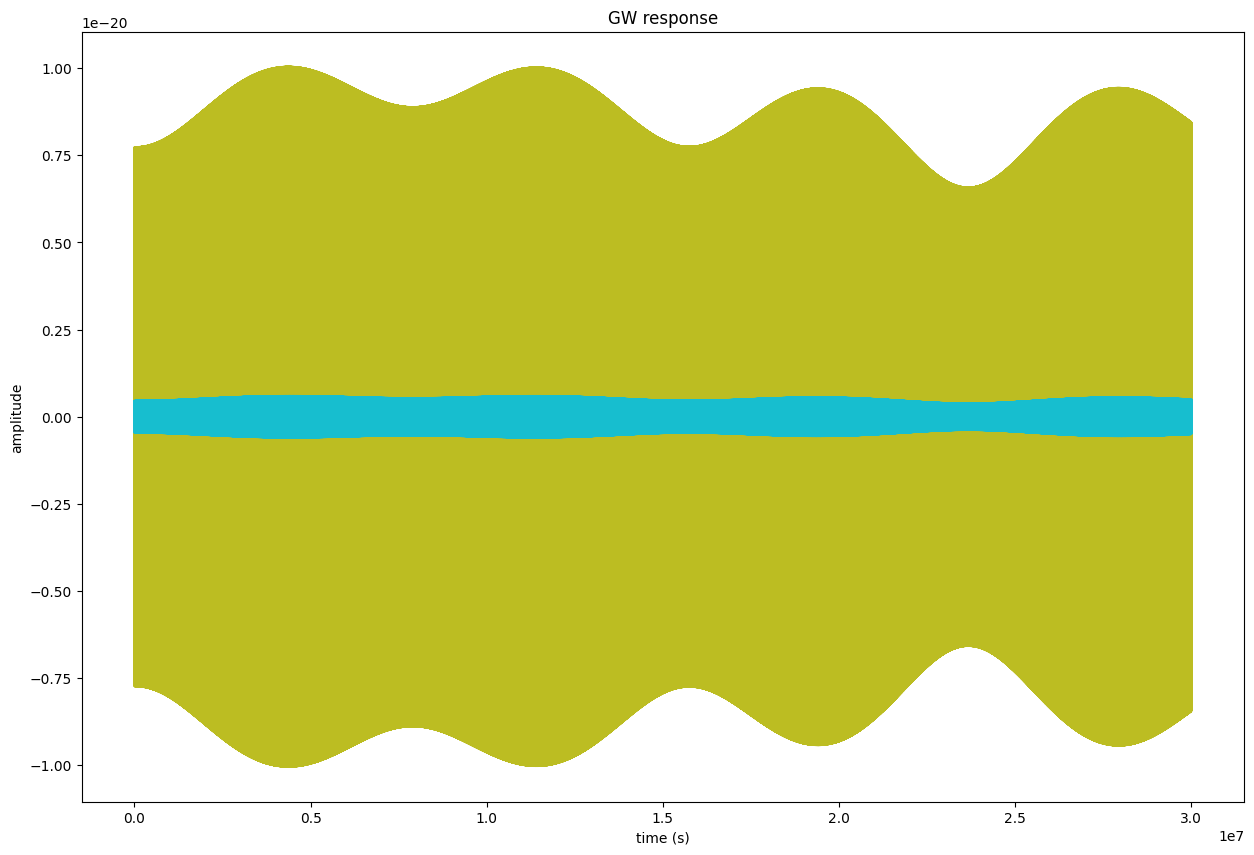

In [44]:
tp = orbit_t0 + np.arange(0,Tobs,dt)

plt.figure(figsize=(15,10))
for i in range(value):
   
    plt.plot(tp[10:], tab_X2gw[i][10:])
    
plt.title('GW response')
plt.xlabel('time (s)')
plt.ylabel('amplitude')
#plt.savefig('GWres_pos.png')
plt.show()  



In [12]:
#SNR

[1.5801335040305023e-14, 0.00432127831580315, 1.3885847012674448, 34.12901311832721, 266.02742664917525, 1110.650581549563, 3129.7912465934473, 6395.623285700488, 8582.164987199949, 373.34228308257343]


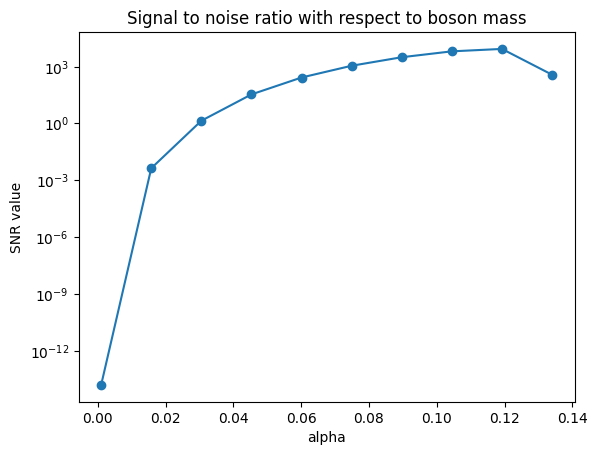

In [17]:
SNRc_X2 = []
SNR_X2 = []

#SNRc_A2 = []
#SNRc_E2 = []
#SNRc_A2 = []
#SNR_tot=[]
#for i in range(value):
#    SNRc_A2.append([])
#    SNRc_E2.append([])
#    SNRc_T2.append([])
#   SNRc_tot.append([])

for i in range(value):
    SNRc_X2.append([])
    SNR_X2.append([])
    
def SNR_carre(P_d,Sn_f):
    
    return 4*np.real(np.sum((P_d/(Sn_f))))*(1/Tobs)


for i in range(value):
    SNRc_X2.append(SNR_carre((dt*np.abs(np.fft.rfft(tab_X2gw[i]))[1:]),tab_PSD_sciRD_X2usb[i]))
    SNR_X2[i]=(np.sqrt(SNR_carre((dt*np.abs(np.fft.rfft(tab_X2gw[i]))[1:])**2,tab_PSD_sciRD_X2usb[i][:])))

    
plt.figure()
plt.semilogy(alphas,SNR_X2, marker='o')
plt.title('Signal to noise ratio with respect to boson mass')
plt.ylabel('SNR value')
plt.xlabel('alpha')
print(SNR_X2)

In [22]:
import gwaxion

SNR_theo_b=[]

## Armlength in seconds
c = 299792458.0
L_m = 2.5e9
L = L_m/c
distance = 8e3 * gwaxion.PC_SI

def SNRc_theo(h0,Tobs,Sh_theo):
    return 5*((2/5*h0)**2*Tobs/Sh_theo)

for a in alphas :
    bhb = gwaxion.BlackHoleBoson.from_parameters(m_bh=10**6, alpha=a, chi_bh=0.5)
    bh = gwaxion.BlackHole(mass=10**6, chi=0.5, msun=True)
    cloud = bhb.best_cloud()
    fgw=cloud.fgw
    h0 = bh.h0r_fit(fgw)/distance
    print('GW frequency=',fgw)
    print('h0= : ',h0)
    print('----------------------------------')
    omegaL = 2*np.pi*fgw*L
    PSD_fX2 = get_noise_model("SciRDv1",fgw).psd(option='X',tdi2=True)
    S_theoX2=(20/3)*(1+0.6*(omegaL)**2)*(PSD_fX2/((4*omegaL)**2*(np.sin(omegaL)**2)*(2*np.sin(2*omegaL))**2))
    SNR_theo_b.append(np.sqrt(SNRc_theo(h0,Tobs,S_theoX2)))

   

print(SNR_theo_b)

GW frequency= 6.46054806813896e-05
h0= :  2.321742106517345e-37
----------------------------------
GW frequency= 0.0010192997707692286
h0= :  2.382017357070072e-25
----------------------------------
GW frequency= 0.001973831737500581
h0= :  1.9094551261764027e-23
----------------------------------
GW frequency= 0.0029280521203597343
h0= :  2.360376693329662e-22
----------------------------------
GW frequency= 0.003881811252604445
h0= :  1.3285915899867745e-21
----------------------------------
GW frequency= 0.004834952956758404
h0= :  4.6684437161582595e-21
----------------------------------
GW frequency= 0.005787310342280484
h0= :  1.1805672326758299e-20
----------------------------------
GW frequency= 0.006738699629344109
h0= :  2.214660175146824e-20
----------------------------------
GW frequency= 0.0076889119422660366
h0= :  2.732429466871289e-20
----------------------------------
GW frequency= 0.008648785615999603
h0= :  0.0
----------------------------------
[4.812944154713539e-1

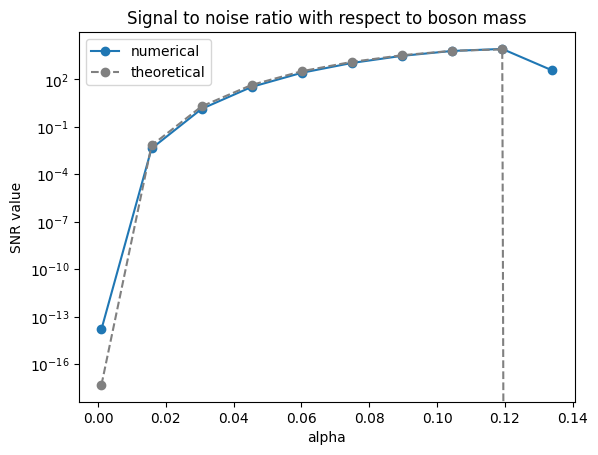

In [45]:
plt.figure()
plt.semilogy(alphas,SNR_X2, marker='o',label='numerical')
plt.semilogy(alphas,SNR_theo_b, marker='o',ls='--',c='gray',label='theoretical')
plt.title('Signal to noise ratio with respect to boson mass')
plt.ylabel('SNR value')
plt.xlabel('alpha')
plt.legend()
plt.savefig('SNR_b.png')

In [27]:
print(alphas)

[0.001      0.01577778 0.03055556 0.04533333 0.06011111 0.07488889
 0.08966667 0.10444444 0.11922222 0.134     ]
